In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error

fred = Fred(api_key="388e4633f23c88b89679b89794f572ed")
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

In [41]:
# loans = fred.get_series("CCLACBW027SBOG").rename("loans")
loans = pd.read_csv('consumerloans_clean.csv', index_col=0, parse_dates=True).rename(columns={"consumerloans": "loans"})
claims = fred.get_series("ICSA").rename('claims')  # Weekly
eff_funds = fred.get_series("FF").rename('eff_funds')  # Weekly
deposits = fred.get_series("DPSACBW027SBOG").rename('deposits')  # Weekly

arimax_df = pd.DataFrame(loans)
for s in [eff_funds, deposits]:
    arimax_df = pd.merge_asof(arimax_df, s, left_index=True, right_index=True)
arimax_df[['eff_funds_l1', 'deposits_l1']] = arimax_df[['eff_funds', 'deposits']].shift(1).bfill()
arimax_df['deposits_l1_log_ret'] = np.log(arimax_df['deposits_l1']).diff().bfill()

In [42]:
arimax_df

,loans,eff_funds,deposits,eff_funds_l1,deposits_l1,deposits_l1_log_ret
date,,,,,,
2000-06-28,551.643510,6.53,3576.1524,6.53,3576.1524,0.000000
2000-07-05,554.377885,6.85,3625.4808,6.53,3576.1524,0.000000
2000-07-12,553.241385,6.44,3613.4882,6.85,3625.4808,0.013699
2000-07-19,554.903785,6.50,3619.9306,6.44,3613.4882,-0.003313
2000-07-26,554.138385,6.50,3639.3521,6.50,3619.9306,0.001781
...,...,...,...,...,...,...
2024-03-13,1053.400000,5.33,17535.5968,5.33,17494.1022,0.002918
2024-03-20,1054.565700,5.33,17568.9661,5.33,17535.5968,0.002369
2024-03-27,1053.803300,5.33,17645.4336,5.33,17568.9661,0.001901


In [43]:
p=q=range(7)
arimax_models = np.empty((len(p), len(q)), dtype=object)
arimax_results = np.empty((len(p), len(q)), dtype=object)
for ar_lags in tqdm(p):
    for ma_lags in q:
        arimax = ARIMA(
            arimax_df.loans,
            order=(ar_lags, 1, ma_lags),
            exog=arimax_df[['eff_funds_l1', 'deposits_l1_log_ret']],
        )
        arimax_models[ar_lags, ma_lags] = arimax
        arimax_results[ar_lags, ma_lags] = arimax.fit()
arimax_aics = np.array(list(map(lambda r: r.aic, arimax_results.flatten()))).reshape(
    len(p), len(q)
)
arimax_aics = pd.DataFrame(arimax_aics, index=p, columns=q)

100%|██████████| 7/7 [00:40<00:00,  5.79s/it]


In [44]:
arima_models = np.empty((len(p), len(q)), dtype=object)
arima_results = np.empty((len(p), len(q)), dtype=object)
for ar_lags in tqdm(p):
    for ma_lags in q:
        arima = ARIMA(
            arimax_df.loans,
            order=(ar_lags, 1, ma_lags),
        )
        arima_models[ar_lags, ma_lags] = arima
        arima_results[ar_lags, ma_lags] = arima.fit()
arima_aics = np.array(list(map(lambda r: r.aic, arima_results.flatten()))).reshape(
    len(p), len(q)
)
arima_aics = pd.DataFrame(arima_aics, index=p, columns=q)

100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


In [28]:
arima_aics

,0,1,2,3,4,5,6
0,5893.474225,5857.960885,5854.390152,5853.715282,5772.339611,5760.109527,5761.850614
1,5852.367088,5768.527580,5768.448444,5767.951067,5761.692919,5729.581966,5727.998905
2,5847.725236,5768.700824,5769.659671,5769.924526,5763.631942,5729.860836,5596.662352
3,5831.802553,5766.594730,5766.124471,5578.820335,5582.036632,5770.371716,5694.317553
4,5744.447336,5738.904189,5604.636117,5571.499136,5581.114160,5569.702597,5562.405042
5,5735.151882,5735.806085,5577.167194,5562.305978,5562.787607,5585.242101,5592.741368
6,5733.936916,5735.145290,5579.902140,5579.455394,5555.516799,5591.362521,5590.088880


In [46]:
arimax_aics

,0,1,2,3,4,5,6
0,5880.769291,5843.588526,5840.658209,5841.210082,5762.263539,5746.363016,5747.916278
1,5838.230391,5758.072386,5756.959720,5755.992364,5749.394391,5719.340271,5715.484411
2,5835.165993,5757.382514,5757.967702,5757.920660,5751.374065,5718.711930,5595.363310
3,5820.714509,5754.242295,5753.390053,5561.337844,5561.917652,5543.359290,5535.332700
4,5731.653879,5724.820502,5584.812263,5554.721744,5563.571453,5551.320230,5544.446616
5,5719.649216,5719.377427,5562.113769,5550.708439,5545.410345,5567.784275,5571.959928
6,5716.515608,5717.726001,5560.878110,5561.922684,5535.922385,5574.313009,5560.620315


In [47]:
arima_aics.stack().idxmin()

(6, 4)

In [48]:
arimax_aics.stack().idxmin()

(3, 6)

In [33]:
arimax_results[3,6].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  loans   No. Observations:                 1242
Model:                 ARIMA(3, 1, 6)   Log Likelihood               -2755.680
Date:                Thu, 25 Apr 2024   AIC                           5535.361
Time:                        17:21:21   BIC                           5596.845
Sample:                    06-28-2000   HQIC                          5558.483
                         - 04-10-2024                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
eff_funds_l1            1.4939      0.465      3.211      0.001       0.582       2.406
deposits_l1_log_ret   -37.0718      5.210     -7.116      0.000     -47.283     -26.861
ar.L1                   1.2142      0.015     79.343      0.000       1.184       1.244
ar.L2                  -1.2374      0.005   -248.209      0.000      -1.247      -1.228
ar.L3                   0.9636      0.015     63.656      0.000       0.934       0.993
ma.L1                  -1.1323      0.023    -49.955      0.000      -1.177      -1.088
ma.L2                   1.3254      0.034     38.990      0.000       1.259       1.392
ma.L3                  -0.9461      0.045    -21.176      0.000      -1.034      -0.859
ma.L4                   0.0812      0.046      1.773      0.076      -0.009       0.171
ma.L5                  -0.0330      0.033     -1.006      0.314      -0.097       0.031
ma.L6                  -0.0820      0.024     -3.458      0.001      -0.129      -0.036
sigma2                  4.9710      0.130     38.286      0.000       4.717       5.225
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1330.35
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.56
Prob(H) (two-sided):                  0.66   Kurtosis:                         7.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
with open("arimax_results.txt", "w") as f:
    f.write(arimax_results[3, 6].summary().as_text())

In [11]:
exog_forecast = np.zeros((52,2))

In [50]:
ieffr = pd.read_csv('ieffr.csv')
ieffr.set_index('Date', inplace=True)
exog_forecast[:, 0] = ieffr['Implied EFFR'].values

Main forecast for next 2 years. ARIMAX (3,1,6). Only uses IFFER as exogenous variable. Maybe the plot should be made more pretty.

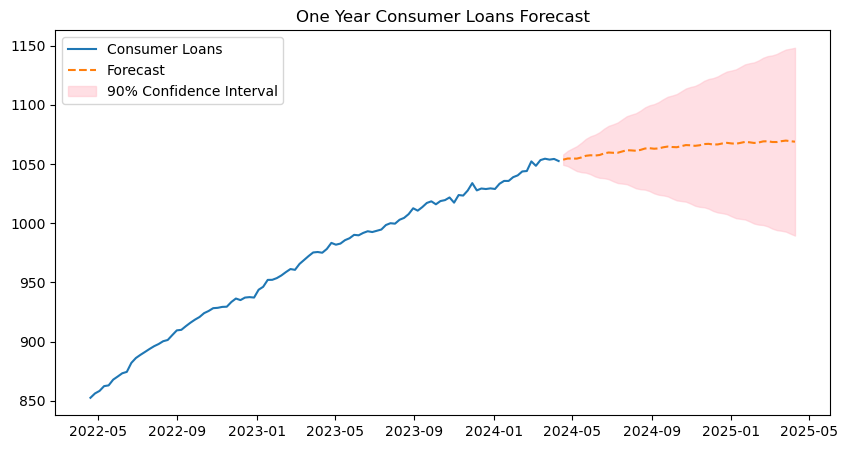

<Axes: >

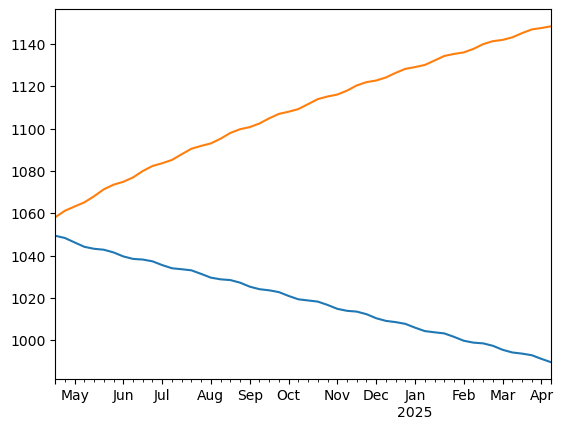

In [75]:
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(loans[-104:], label='Consumer Loans')
fc = arimax_results[3,6].get_forecast(steps=52, exog=exog_forecast).summary_frame()
plt.plot(fc['mean'], linestyle='dashed', label='Forecast')
plt.fill_between(fc.index, fc.mean_ci_upper, fc.mean_ci_lower, color='pink', alpha=0.5, label='90% Confidence Interval')
plt.legend(loc='upper left')

# Show the plot
plt.title('One Year Consumer Loans Forecast')
plt.show()

fc['mean_ci_lower'].plot()
fc['mean_ci_upper'].plot()

In [76]:
fc

loans,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-04-17,1053.748105,2.229570,1049.378229,1058.117981
2024-04-24,1054.746171,3.284626,1048.308423,1061.183919
2024-05-01,1054.700463,4.335443,1046.203151,1063.197775
2024-05-08,1054.649209,5.359088,1044.145589,1065.152830
2024-05-15,1055.631683,6.335618,1043.214101,1068.049266
2024-05-22,1057.043424,7.282025,1042.770917,1071.315931
2024-05-29,1057.492412,8.162651,1041.493910,1073.490915
2024-06-05,1057.237414,8.990030,1039.617279,1074.857549
2024-06-12,1057.682581,9.817554,1038.440529,1076.924632
2024-06-19,1059.032054,10.661554,1038.135793,1079.928315


Making one step ahead 

In [77]:
#getting most recent value for deposits
deposits_log_ret = np.log(arimax_df['deposits_l1']).diff().bfill()
deposits_log_ret

exog_forecast1 = np.zeros((1,2))
exog_forecast1[0, 0] = ieffr['Implied EFFR'].values[0]
exog_forecast1[0, 1] = deposits_log_ret[-1]

fc1 = arimax_results[3,6].get_forecast(steps=1, exog=exog_forecast1).summary_frame()
fc1

loans,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-04-17,1053.883797,2.22957,1049.513921,1058.253674


making table of forecasts for the appendix

In [137]:
forecast_table = fc.copy()
forecast_table.iloc[0] = fc1.iloc[0]
forecast_table.drop('mean_se', axis=1, inplace=True)
forecast_table.reset_index(inplace=True)
forecast_table.rename(columns={'index': 'Date'}, inplace=True)
forecast_table.rename(columns={'mean': 'Point Forecast', 'mean_ci_lower': '5th Percentile Forecast', 'mean_ci_upper': '95th Percentile Forecast'}, inplace=True)
forecast_table = forecast_table.round(2)
forecast_table

loans,Date,Point Forecast,5th Percentile Forecast,95th Percentile Forecast
0,2024-04-17,1053.88,1049.51,1058.25
1,2024-04-24,1054.75,1048.31,1061.18
2,2024-05-01,1054.70,1046.20,1063.20
3,2024-05-08,1054.65,1044.15,1065.15
4,2024-05-15,1055.63,1043.21,1068.05
5,2024-05-22,1057.04,1042.77,1071.32
6,2024-05-29,1057.49,1041.49,1073.49
7,2024-06-05,1057.24,1039.62,1074.86
8,2024-06-12,1057.68,1038.44,1076.92
9,2024-06-19,1059.03,1038.14,1079.93


In [138]:
forecast_table.to_csv('forecast_table.csv', index=False)